In [ ]:
from rdkit import Chem
from glob import glob
from rdkit.Chem import rdMolTransforms
import numpy as np
import pickle


In [ ]:
def sp2_indices(mol):
    sp2_index = []
    atoms = mol.GetAtoms()
    bonded = []
    for bond in mol.GetAtoms()[0].GetBonds():
        bonded.append(bond.GetEndAtomIdx())
    for atom in atoms:
        neighbors = atom.GetNeighbors()
        if len(neighbors) == 3:
            for a, b in ((0, 1), (1, 2), (2, 0)):
                angle = rdMolTransforms.GetAngleDeg(mol.GetConformer(),bonded[a],0,bonded[b])
                if (angle > 109 and angle < 145):
                    sp2_index.append(atom.GetIdx())
    return list(set(sp2_index))

In [4]:
def connectivity_matrix(mol):
    atoms = mol.GetAtoms()
    carbons = [atom for atom in atoms if atom.GetAtomicNum() == 6 ]
    carbons_idx = [int(carbon.GetIdx()) for carbon in carbons]
    conmat = np.eye(len(carbons))
    for idx in carbons_idx:
        neighbors = atoms[idx].GetNeighbors()
        for nei in neighbors:
            nei_idx = int(nei.GetIdx())
            if nei_idx in carbons_idx:
                conmat[nei_idx,idx] = -1
            else:
                pass
    return conmat-np.eye(len(carbons))

In [5]:
def num_carbons(mol):
    atoms = mol.GetAtoms()
    return len([atom for atom in atoms if atom.GetAtomicNum() == 6 ])

In [6]:
def is_fully_aromatic(mol):
    if len(sp2_indices(mol)) == num_carbons(mol):
        return True
    else:
        return False

In [7]:
# list to hold all our database

pdbs = glob('*pdb')

allsp2_dict = []
for item in pdbs:
    m = Chem.MolFromPDBFile(item, sanitize=False)
    print('new molecule:  ' + item + ' nr# of atoms: ' + str(m.GetNumAtoms()))
    if is_fully_aromatic(m):
        allsp2_dict.append({'name' : item[:-4], 'conmat' : connectivity_matrix(m), 'num_carbon': num_carbons(m)})
    else:
        print('WARNING: ' + item + ' is not fully aromatic, thus skipped.')

# pickle
pickle.dump( allsp2_dict, open( "pahs.pkl", "wb" ) )

new molecule:  1',9-Methylene-1,2-benzanthracene.pdb nr# of atoms: 31
new molecule:  1,10-(1,2-Phenylene)pyrene.pdb nr# of atoms: 34
new molecule:  1,10-(o-Phenylene)pyrene.pdb nr# of atoms: 34
new molecule:  1,12-Benzoperylene.pdb nr# of atoms: 34
new molecule:  1,2,3,4-Dibenznaphthalene.pdb nr# of atoms: 30
new molecule:  1,2,5,6-Dibenzofluorene.pdb nr# of atoms: 35
new molecule:  1,2-(1,8-Naphthalenediyl)benzene.pdb nr# of atoms: 26
new molecule:  1,2-Benzanthracene.pdb nr# of atoms: 30
new molecule:  1,2-Benzanthrene.pdb nr# of atoms: 30
new molecule:  1,2-Benzofluorene.pdb nr# of atoms: 29
new molecule:  1,2-Benzoperylene.pdb nr# of atoms: 38
new molecule:  1,2-Benzophenanthrene.pdb nr# of atoms: 30
new molecule:  1,2-Benzpyrene.pdb nr# of atoms: 32
new molecule:  1,2-Dihydroacenaphthylene.pdb nr# of atoms: 22
new molecule:  1,8-Ethylenenaphthalene.pdb nr# of atoms: 22
new molecule:  10,11-Benzofluoranthene.pdb nr# of atoms: 32
new molecule:  10H-Benz[g]indeno[2,1-a]phenanthrene.p

new molecule:  9H-Benz[4,5]indeno[2,1-c]phenanthrene.pdb nr# of atoms: 41
new molecule:  9H-Benz[5,6]indeno[2,1-c]phenanthrene.pdb nr# of atoms: 41
new molecule:  9H-Fluorene.pdb nr# of atoms: 23
new molecule:  9H-Indeno[1,2-e]pyrene.pdb nr# of atoms: 37
new molecule:  9H-Indeno[2,1-c]phenanthrene.pdb nr# of atoms: 35
new molecule:  9H-Naphtho[1,2,3-cd]perylene.pdb nr# of atoms: 43
new molecule:  Aceanthrylene.pdb nr# of atoms: 26
new molecule:  Acenaphthalene.pdb nr# of atoms: 20
new molecule:  Acenaphthene.pdb nr# of atoms: 22
new molecule:  Acenaphtho[1,2,3-cde]pyrene.pdb nr# of atoms: 36
new molecule:  Acenaphtho[1,2-b]phenanthrene.pdb nr# of atoms: 38
new molecule:  Acenaphtho[1,2-j]fluoranthene.pdb nr# of atoms: 40
new molecule:  Acenaphtho[1,2-k]cyclopenta[cd]fluoranthene.pdb nr# of atoms: 42
new molecule:  Acenaphtho[1,2-k]fluoranthene.pdb nr# of atoms: 40
new molecule:  Acenaphthylene.pdb nr# of atoms: 20
new molecule:  Acenaphth[1,2-a]anthracene.pdb nr# of atoms: 38
new molec

In [8]:
def choose_n(myid, choices, n_molecules=10):
    import random
    random.seed(myid)
    subset = random.sample(list(choices), n_molecules)
    return subset

In [9]:
def generate_dataset(myid=None, n_molecules=10, n_carbon_atoms=24, debug=False):
    """
    This function picks 10 random molecules from a database based on your student ID.
    """
    
    allsp2_dict = pickle.load( open( "pahs.pkl", "rb" ) )
    maxidx = len(allsp2_dict)
    if debug:
        print(' | --- Total number of fully aromatic molecules in database: ' + str(maxidx))
        print(' | --- By number of carbon atoms: ')
    # number of fully conjugated molecules by number of carbon atoms
        for num in range(2,40,2):
            print('      len = ' + str(num) + ' : molecules = ' + str(len([mol for mol in allsp2_dict if mol['num_carbon'] == num])))

    print(' | --- Your molecule dataset contains molecules with {0} sp2 hybridised carbon atoms'.format(n_carbon_atoms))
    # Since we only have more than 100 for 24 and 30 atoms I chose 24
    equal_carbon_number = [elm for elm in allsp2_dict if elm['num_carbon'] == n_carbon_atoms]

    print(' | --- Based on your student ID we chose the following molecules for you: ')

    subset = choose_n(myid, equal_carbon_number, n_molecules)
    mols = []
    legend = []
    for pmol in subset:
        print('      ' + pmol['name'])
        legend.append(pmol['name'])
        mols.append(Chem.MolFromMolFile(pmol['name']+'.mol'))

    return subset, mols, legend

In [13]:
dataset, mols, legend = generate_dataset(myid=1673606, n_molecules=2, n_carbon_atoms=12, debug=True)

 | --- Total number of fully aromatic molecules in database: 531
 | --- By number of carbon atoms: 
      len = 2 : molecules = 0
      len = 4 : molecules = 0
      len = 6 : molecules = 3
      len = 8 : molecules = 0
      len = 10 : molecules = 2
      len = 12 : molecules = 4
      len = 14 : molecules = 1
      len = 16 : molecules = 9
      len = 18 : molecules = 22
      len = 20 : molecules = 39
      len = 22 : molecules = 43
      len = 24 : molecules = 110
      len = 26 : molecules = 71
      len = 28 : molecules = 47
      len = 30 : molecules = 111
      len = 32 : molecules = 33
      len = 34 : molecules = 19
      len = 36 : molecules = 16
      len = 38 : molecules = 1
 | --- Your molecule dataset contains molecules with 12 sp2 hybridised carbon atoms
 | --- Based on your student ID we chose the following molecules for you: 
      Acenaphthalene
      Cyclopenta[de]naphthalene


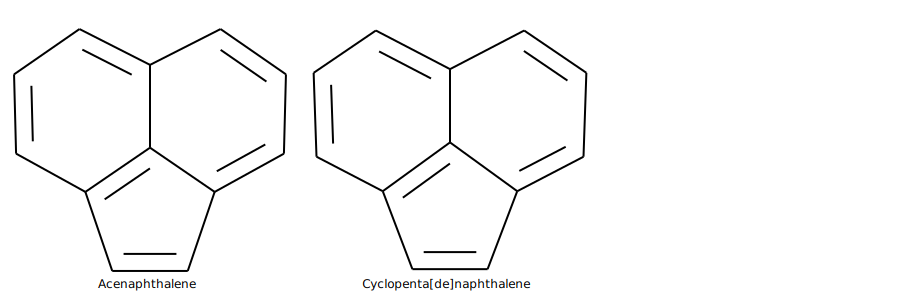

In [14]:
from rdkit import Chem
import rdkit.Chem.Draw
from rdkit.Chem import AllChem
from IPython.display import SVG

SVG(Chem.Draw.MolsToGridImage(mols, useSVG=True, legends=legend, subImgSize=(300,300)))